<a href="https://colab.research.google.com/github/kevinkevin556/Dlchemist/blob/main/nin2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Network in Network**

# **Section 1. Set up**

In [1]:
!pip install einops
!pip install scipy==1.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### *Dataset and DataLoader*


How to normalize CIFAR-10: [link](https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py).

In [3]:
from torch.utils.data import Dataset, random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, ToPILImage, Normalize

cifar10 = CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
data_means = (cifar10.data / 255.0).mean(axis=(0,1,2))
data_std = (cifar10.data / 255.0).std(axis=(0,1,2))
print("Data mean", data_means)
print("Data std", data_std)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


In [4]:
from torch.utils.data import Dataset, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, ToPILImage
from einops import rearrange


class CIFAR10Dataset(Dataset):
  def __init__(self, root="./data", mean=None, W=None,train=False, download=True, index=None):
    
    cifar10 = CIFAR10(root, train, download=download)

    if index is None:
      self.data, self.targets = cifar10.data, cifar10.targets
    else:
      self.data = cifar10.data[index]
      self.targets = [cifar10.targets[i] for i in index]

    self.mean = self.data.mean(axis=0) if mean is None else mean
    self.W = self.zca_matrix((self.data-self.mean)/255.0) if W is None else W


  def __len__(self):
    return len(self.data)


  def __getitem__(self, idx):
    image, label = self.data[idx], self.targets[idx]
    image = (image - self.mean)/255     # normalization
    image = self.whiten(image)          # zca-whitening
    return image, label


  def zca_matrix(self, images):
    n = len(self.targets)  
    images = rearrange(images, 'N H W C -> N (H W C)')
    cov = torch.cov(Tensor(images.T))
    L, V = torch.linalg.eig(cov)
    L, V = L.real, V.real
    W = V @ torch.diag(L**(-0.5)) @ V.T
    return W


  def whiten(self, image):
    ## Add a dimension
    image = rearrange(image, 'H W C -> 1 (H W C)')
    
    ## Whiten the image
    whiten_image =  Tensor(image) @ self.W 
    
    ## Tensorize the image: (dim=(c, h, w) & range=(0, 1))
    whiten_image = rearrange(whiten_image, 'N (H W C) -> C (N H) W', C=3, N=1, H=32)
    whiten_image = torch.clip(whiten_image, 0, 1)
    return whiten_image

[ZCA1](https://stats.stackexchange.com/questions/117427/what-is-the-difference-between-zca-whitening-and-pca-whitening)
[ZCA2](https://towardsdatascience.com/pca-whitening-vs-zca-whitening-a-numpy-2d-visual-518b32033edf#:~:text=ZCA%2Dwhitening%20is%20done%20by,possible%20from%20the%20original%20data.)

In [5]:
# Generate indices to permute the training data and conduct train-test-split
total_size = 50000
valid_size = total_size // 10
rng = np.random.default_rng(42)
indices = rng.permutation(total_size)

train_dataset = CIFAR10Dataset(train=True, index=indices[:-valid_size])
mean = train_dataset.mean
W = train_dataset.W

valid_dataset = CIFAR10Dataset(train=True, mean=mean, W=W, index=indices[-valid_size:])
test_dataset = CIFAR10Dataset(train=False, mean=mean, W=W)


print("\nData Size:")
print("* Training set   => ", len(train_dataset), "images")
print("* Validation set => ", len(valid_dataset), "images")
print("* Testing set    => ", len(test_dataset), "images")

print("\nImage Shape (C, H, W):")
print("* Training image:", train_dataset[0][0].shape)
print("* Testing image: ", test_dataset[0][0].shape)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified

Data Size:
* Training set   =>  45000 images
* Validation set =>  5000 images
* Testing set    =>  10000 images

Image Shape (C, H, W):
* Training image: torch.Size([3, 32, 32])
* Testing image:  torch.Size([3, 32, 32])


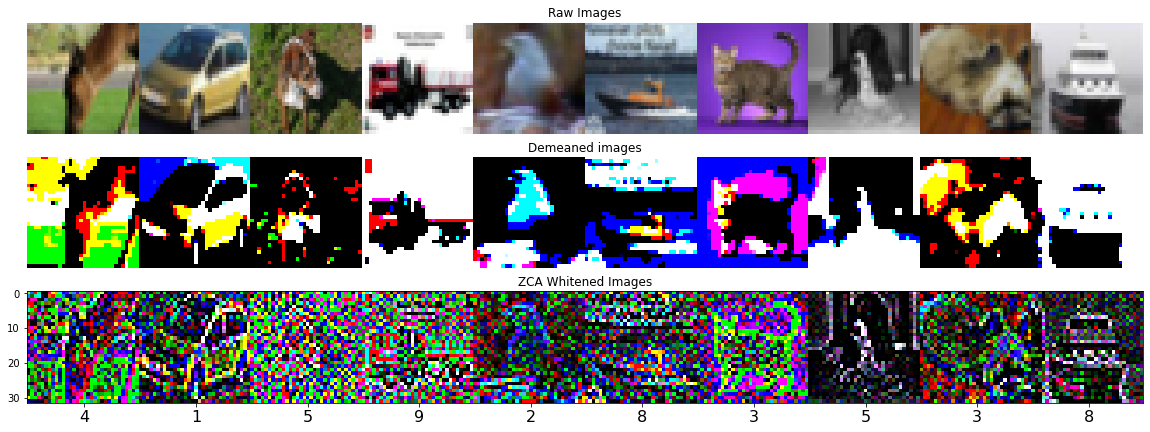


Image shape: (3, 32, 32)


In [6]:
import matplotlib.pyplot as plt

n_view = 10
pil_dstack = lambda images: ToPILImage()(torch.dstack(images))

# Sample images
raw_images = np.hstack([train_dataset.data[i] for i in range(n_view)])
demeaned_images = np.hstack([train_dataset.data[i] - mean for i in range(n_view)])
images = pil_dstack([train_dataset[i][0] for i in range(n_view)])
targets = [train_dataset[i][1] for i in range(n_view)]

fig, ax = plt.subplots(3, 1, figsize=(20, 7))
ax[0].imshow(raw_images)
ax[0].set_title("Raw Images")
ax[0].axis('off')

ax[1].imshow(demeaned_images)
ax[1].set_title("Demeaned images")
ax[1].axis('off')

ax[2].imshow(images)
ax[2].set_title("ZCA Whitened Images")
ax[2].set_xticks(ticks=np.array(range(10))*32+16)
ax[2].set_xticklabels(targets, {'fontsize':16})
plt.show()
plt.close()


image_shape = tuple(train_dataset[0][0].shape)
print("\nImage shape:", image_shape)

In [7]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

### *Network Architecture*

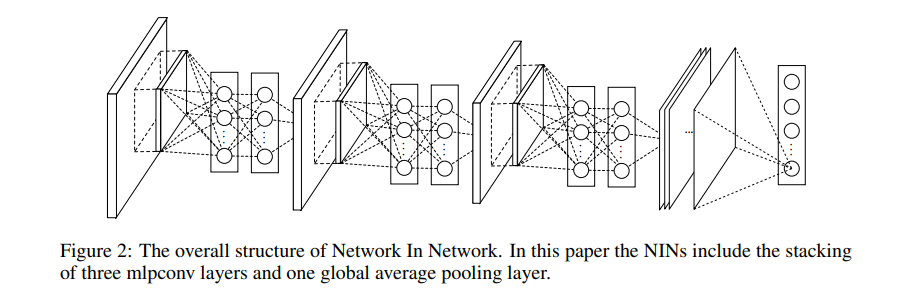

The network architecture is built based on this [prototext](https://gist.github.com/mavenlin/e56253735ef32c3c296d) from the Caffe model zoo. Note one should set `MaxPool2d(ceil_mode=True)` to get the correct dimension.


In [8]:
from torch.nn import (
    Conv2d, ReLU, MaxPool2d, AvgPool2d, Dropout, Sequential, Flatten
)


def CCCP(in_channels, out_channels):
  return Conv2d(in_channels, out_channels, kernel_size=1)

def MlpConv(in_channels, hidden_channels, out_channels, kernel_size, stride=1, padding=0):
  return nn.Sequential(
      Conv2d(in_channels, hidden_channels[0], kernel_size, stride, padding),
      ReLU(),
      CCCP(hidden_channels[0], hidden_channels[1]),
      ReLU(),
      CCCP(hidden_channels[1], out_channels),
      ReLU()
  )

class NiN(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.net = Sequential(
        MlpConv(3, (192, 160), 96, kernel_size=5, padding=2),
        MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        Dropout(p=0.5),

        MlpConv(96, (192, 192), 192, kernel_size=5, padding=2),
        AvgPool2d(kernel_size=3, stride=2, ceil_mode=True),
        Dropout(p=0.5),

        MlpConv(192, (192, 192), num_classes, kernel_size=3, padding=1),
        AvgPool2d(kernel_size=8, stride=1),
        Flatten()
    )

    # Remember to initialize the weights and biases.
    # Default initialization from pytorch doesn't work well.
    self.net.apply(self.init_weights)

  def forward(self, x):
    return self.net(x)

  @staticmethod
  def init_weights(m):
    if isinstance(m, Conv2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.05)
        torch.nn.init.zeros_(m.bias)

print(NiN())

NiN(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(192, 160, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(160, 96, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Sequential(
      (0): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (4): AvgPool2d(kernel_size=3, stride=2, padding=0)
    (5): Dropout(p=0.5, inplace=False)
    (6): Sequential(
      (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
      (3)

In [9]:
# Check forward path
X = torch.randn(1, *image_shape)
print(f"{'Image shape:':25s} {list(X.shape)}")
for layer in NiN().net:
    X=layer(X)
    print(f"{layer.__class__.__name__+' output shape:':25s} {list(X.shape)}")

Image shape:              [1, 3, 32, 32]
Sequential output shape:  [1, 96, 32, 32]
MaxPool2d output shape:   [1, 96, 16, 16]
Dropout output shape:     [1, 96, 16, 16]
Sequential output shape:  [1, 192, 16, 16]
AvgPool2d output shape:   [1, 192, 8, 8]
Dropout output shape:     [1, 192, 8, 8]
Sequential output shape:  [1, 10, 8, 8]
AvgPool2d output shape:   [1, 10, 1, 1]
Flatten output shape:     [1, 10]


### *Validation Step*

In [10]:
def validate(model, dataloader, device=torch.device('cuda')):
  model.eval()
  acc = []

  with torch.no_grad():
    for images, targets in dataloader:
      images, targets = images.to(device), targets.to(device)
      preds = model(images)
      pred_labels = torch.argmax(preds, dim=1)
      acc.append((pred_labels == targets).type(torch.float32).mean().item())
  
  return acc

### *Testing Step*

In [11]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def test(model, dataloader, class_names=None, device=torch.device('cuda')):
  model.eval()
  np_pred_labels = []
  np_targets = []

  # Obtain predictions and ground truths
  with torch.no_grad():
      for images, targets in test_dataloader:
          images, targets = images.to(device), targets.to(device)
          preds = test_model(images)
          pred_labels = torch.argmax(preds, dim=1)
          
          pred_labels = pred_labels.view(-1).detach().cpu().numpy()
          targets = targets.view(-1).detach().cpu().numpy()

          np_pred_labels.append(pred_labels)
          np_targets.append(targets)

  ## Calculate confusion matrix
  np_pred_labels = np.concatenate(np_pred_labels)
  np_targets = np.concatenate(np_targets)
  conf_mat = confusion_matrix(np_targets, np_pred_labels)

  if class_names is not None:
    df_cm = pd.DataFrame(conf_mat, class_names, class_names)
  else:
    df_cm = pd.DataFrame(conf_mat)

  ## Plot confusion matrix
  plt.figure(figsize = (12,8))
  sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
  plt.xlabel("prediction")
  plt.ylabel("label (ground truth)")
  plt.show()

  ## print class accuracy
  for i in range(len(df_cm)):
    total = np.sum(df_cm.iloc[i, :])
    correct = df_cm.iloc[i, i]
    print(f"Acc of {df_cm.columns[i]}: {correct/total:.4f}")
  
  ## print total accuracy
  print("\nTotal Acc:", np.mean(np_targets == np_pred_labels))

### *Training Step*

In [12]:
def train(
    model,
    criterion,
    optimizer,
    train_dataloader,
    valid_dataloader,
    scheduler = None,
    num_epochs = 1,
    device = torch.device('cuda'),
    state_dict = None
):
  
  best_valid_acc = 0
  
  if state_dict is not None:
    model.load_state_dict(state_dict)

  for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    train_progress = tqdm(train_dataloader, position=0, leave=True)

    ## Train
    for images, targets in train_progress:
      images, targets = images.to(device), targets.to(device)
      preds = model(images)
      loss = criterion(preds, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_value = loss.detach().item()
      batch_losses.append(loss_value)
      train_progress.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
      train_progress.set_postfix({'loss': loss_value})
    
    ## Adjust learning rate after an epoch is finished
    if scheduler is not None:
      scheduler.step()

    ## Validate and save the best model (if any)
    valid_acc = validate(model,  valid_dataloader)
    print(f"Train Loss: {np.mean(batch_losses):.3f}, Valid Acc:{np.mean(valid_acc):.3f}")
    if np.mean(valid_acc) > best_valid_acc:
      best_valid_acc = np.mean(valid_acc)
      torch.save(model.state_dict(), "model_state_dict.ckpt")

# **Section 2. Start Training**

### *Optimization Configuration and First Training Stage*

In [13]:
BASE_LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
STEP_SIZE = 1e5
GAMMA = 0.1
NUM_EPOCHS = 230

In [ ]:
nin = NiN(num_classes=10)
nin.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nin.parameters(), BASE_LR, MOMENTUM, 0, WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, STEP_SIZE, GAMMA)

train(nin, criterion, optimizer, train_dataloader, valid_dataloader, scheduler, NUM_EPOCHS)

Epoch [1/230]: 100%|██████████| 352/352 [02:20<00:00,  2.50it/s, loss=2.3]


Train Loss: 2.302, Valid Acc:0.134


Epoch [2/230]: 100%|██████████| 352/352 [02:09<00:00,  2.73it/s, loss=2.3]


Train Loss: 2.299, Valid Acc:0.126


Epoch [3/230]: 100%|██████████| 352/352 [02:14<00:00,  2.63it/s, loss=2.28]


Train Loss: 2.289, Valid Acc:0.128


Epoch [4/230]: 100%|██████████| 352/352 [02:11<00:00,  2.69it/s, loss=2.19]


Train Loss: 2.276, Valid Acc:0.129


Epoch [5/230]: 100%|██████████| 352/352 [02:09<00:00,  2.71it/s, loss=2.26]


Train Loss: 2.262, Valid Acc:0.133


Epoch [6/230]: 100%|██████████| 352/352 [02:11<00:00,  2.68it/s, loss=2.24]


Train Loss: 2.247, Valid Acc:0.159


Epoch [7/230]: 100%|██████████| 352/352 [02:09<00:00,  2.71it/s, loss=2.22]


Train Loss: 2.226, Valid Acc:0.151


Epoch [8/230]: 100%|██████████| 352/352 [02:11<00:00,  2.67it/s, loss=2.15]


Train Loss: 2.193, Valid Acc:0.214


Epoch [9/230]: 100%|██████████| 352/352 [02:13<00:00,  2.64it/s, loss=1.97]


Train Loss: 2.116, Valid Acc:0.255


Epoch [10/230]: 100%|██████████| 352/352 [02:10<00:00,  2.69it/s, loss=2]


Train Loss: 1.950, Valid Acc:0.266


Epoch [11/230]: 100%|██████████| 352/352 [02:11<00:00,  2.67it/s, loss=1.7]


Train Loss: 1.855, Valid Acc:0.300


Epoch [12/230]: 100%|██████████| 352/352 [02:08<00:00,  2.73it/s, loss=1.76]


Train Loss: 1.803, Valid Acc:0.317


Epoch [13/230]: 100%|██████████| 352/352 [02:08<00:00,  2.73it/s, loss=1.75]


Train Loss: 1.758, Valid Acc:0.291


Epoch [14/230]: 100%|██████████| 352/352 [02:09<00:00,  2.71it/s, loss=1.75]


Train Loss: 1.704, Valid Acc:0.389


Epoch [15/230]: 100%|██████████| 352/352 [02:09<00:00,  2.71it/s, loss=1.58]


Train Loss: 1.652, Valid Acc:0.419


Epoch [16/230]: 100%|██████████| 352/352 [02:12<00:00,  2.66it/s, loss=1.5]


Train Loss: 1.605, Valid Acc:0.402


Epoch [17/230]: 100%|██████████| 352/352 [02:12<00:00,  2.66it/s, loss=1.72]


Train Loss: 1.569, Valid Acc:0.402


Epoch [18/230]: 100%|██████████| 352/352 [02:10<00:00,  2.70it/s, loss=1.4]


Train Loss: 1.511, Valid Acc:0.412


Epoch [19/230]: 100%|██████████| 352/352 [02:09<00:00,  2.71it/s, loss=1.36]


Train Loss: 1.458, Valid Acc:0.483


Epoch [20/230]: 100%|██████████| 352/352 [02:09<00:00,  2.71it/s, loss=1.38]


Train Loss: 1.419, Valid Acc:0.485


Epoch [21/230]: 100%|██████████| 352/352 [02:11<00:00,  2.69it/s, loss=1.65]


Train Loss: 1.381, Valid Acc:0.517


Epoch [22/230]: 100%|██████████| 352/352 [02:10<00:00,  2.71it/s, loss=1.19]


Train Loss: 1.366, Valid Acc:0.458


Epoch [23/230]: 100%|██████████| 352/352 [02:15<00:00,  2.60it/s, loss=1.36]


Train Loss: 1.318, Valid Acc:0.499


Epoch [24/230]: 100%|██████████| 352/352 [02:16<00:00,  2.59it/s, loss=1.41]


Train Loss: 1.294, Valid Acc:0.514


Epoch [25/230]: 100%|██████████| 352/352 [02:19<00:00,  2.53it/s, loss=1.24]


Train Loss: 1.266, Valid Acc:0.559


Epoch [26/230]: 100%|██████████| 352/352 [02:17<00:00,  2.56it/s, loss=1.22]


Train Loss: 1.236, Valid Acc:0.549


Epoch [27/230]: 100%|██████████| 352/352 [02:19<00:00,  2.53it/s, loss=1.11]


Train Loss: 1.213, Valid Acc:0.554


Epoch [28/230]: 100%|██████████| 352/352 [02:18<00:00,  2.54it/s, loss=1.2]


Train Loss: 1.195, Valid Acc:0.560


Epoch [29/230]: 100%|██████████| 352/352 [02:20<00:00,  2.51it/s, loss=1.06]


Train Loss: 1.166, Valid Acc:0.570


Epoch [30/230]: 100%|██████████| 352/352 [02:11<00:00,  2.68it/s, loss=1.26]


Train Loss: 1.140, Valid Acc:0.538


Epoch [31/230]: 100%|██████████| 352/352 [02:08<00:00,  2.73it/s, loss=1.27]


Train Loss: 1.146, Valid Acc:0.572


Epoch [32/230]: 100%|██████████| 352/352 [02:09<00:00,  2.71it/s, loss=1.27]


Train Loss: 1.108, Valid Acc:0.573


Epoch [33/230]: 100%|██████████| 352/352 [02:12<00:00,  2.66it/s, loss=0.957]


Train Loss: 1.097, Valid Acc:0.569


Epoch [34/230]: 100%|██████████| 352/352 [02:14<00:00,  2.62it/s, loss=0.924]


Train Loss: 1.064, Valid Acc:0.580


Epoch [35/230]: 100%|██████████| 352/352 [02:10<00:00,  2.70it/s, loss=1.02]


Train Loss: 1.041, Valid Acc:0.561


Epoch [36/230]: 100%|██████████| 352/352 [02:11<00:00,  2.69it/s, loss=1.02]


Train Loss: 1.041, Valid Acc:0.566


Epoch [37/230]: 100%|██████████| 352/352 [02:10<00:00,  2.69it/s, loss=1.1]


Train Loss: 1.031, Valid Acc:0.603


Epoch [38/230]: 100%|██████████| 352/352 [02:09<00:00,  2.71it/s, loss=1.08]


Train Loss: 1.007, Valid Acc:0.585


Epoch [39/230]: 100%|██████████| 352/352 [02:11<00:00,  2.67it/s, loss=1.2]


Train Loss: 0.996, Valid Acc:0.613


Epoch [40/230]: 100%|██████████| 352/352 [02:14<00:00,  2.62it/s, loss=1.15]


Train Loss: 0.968, Valid Acc:0.625


Epoch [41/230]: 100%|██████████| 352/352 [02:10<00:00,  2.71it/s, loss=0.975]


Train Loss: 0.963, Valid Acc:0.585


Epoch [42/230]: 100%|██████████| 352/352 [02:10<00:00,  2.71it/s, loss=0.898]


Train Loss: 0.943, Valid Acc:0.650


Epoch [43/230]: 100%|██████████| 352/352 [02:10<00:00,  2.69it/s, loss=0.995]


Train Loss: 0.932, Valid Acc:0.637


Epoch [44/230]: 100%|██████████| 352/352 [02:15<00:00,  2.60it/s, loss=1.05]


Train Loss: 0.913, Valid Acc:0.642


Epoch [45/230]: 100%|██████████| 352/352 [02:14<00:00,  2.62it/s, loss=0.875]


Train Loss: 0.897, Valid Acc:0.645


Epoch [46/230]: 100%|██████████| 352/352 [02:09<00:00,  2.71it/s, loss=0.805]


Train Loss: 0.887, Valid Acc:0.654


Epoch [47/230]: 100%|██████████| 352/352 [02:13<00:00,  2.63it/s, loss=0.866]


Train Loss: 0.880, Valid Acc:0.661


Epoch [48/230]: 100%|██████████| 352/352 [02:12<00:00,  2.66it/s, loss=0.841]


Train Loss: 0.861, Valid Acc:0.654


Epoch [49/230]: 100%|██████████| 352/352 [02:10<00:00,  2.71it/s, loss=0.792]


Train Loss: 0.857, Valid Acc:0.645


Epoch [50/230]: 100%|██████████| 352/352 [02:10<00:00,  2.70it/s, loss=1.21]


Train Loss: 0.843, Valid Acc:0.680


Epoch [51/230]: 100%|██████████| 352/352 [02:10<00:00,  2.70it/s, loss=0.739]


Train Loss: 0.819, Valid Acc:0.641


Epoch [52/230]: 100%|██████████| 352/352 [02:12<00:00,  2.66it/s, loss=0.9]


Train Loss: 0.818, Valid Acc:0.653


Epoch [53/230]: 100%|██████████| 352/352 [02:13<00:00,  2.64it/s, loss=0.631]


Train Loss: 0.810, Valid Acc:0.685


Epoch [54/230]: 100%|██████████| 352/352 [02:13<00:00,  2.64it/s, loss=0.89]


Train Loss: 0.787, Valid Acc:0.669


Epoch [55/230]: 100%|██████████| 352/352 [02:10<00:00,  2.70it/s, loss=0.723]


Train Loss: 0.776, Valid Acc:0.673


Epoch [56/230]: 100%|██████████| 352/352 [02:12<00:00,  2.65it/s, loss=0.559]


Train Loss: 0.757, Valid Acc:0.693


Epoch [57/230]: 100%|██████████| 352/352 [02:11<00:00,  2.67it/s, loss=0.706]


Train Loss: 0.756, Valid Acc:0.680


Epoch [58/230]: 100%|██████████| 352/352 [02:11<00:00,  2.68it/s, loss=0.778]


Train Loss: 0.743, Valid Acc:0.684


Epoch [59/230]: 100%|██████████| 352/352 [02:12<00:00,  2.67it/s, loss=0.828]


Train Loss: 0.733, Valid Acc:0.702


Epoch [60/230]: 100%|██████████| 352/352 [02:10<00:00,  2.70it/s, loss=0.748]


Train Loss: 0.728, Valid Acc:0.668


Epoch [61/230]: 100%|██████████| 352/352 [02:09<00:00,  2.71it/s, loss=0.525]


Train Loss: 0.707, Valid Acc:0.693


Epoch [62/230]: 100%|██████████| 352/352 [02:11<00:00,  2.67it/s, loss=0.795]


Train Loss: 0.710, Valid Acc:0.688


Epoch [63/230]: 100%|██████████| 352/352 [02:09<00:00,  2.71it/s, loss=0.461]


Train Loss: 0.688, Valid Acc:0.717


Epoch [64/230]:  77%|███████▋  | 272/352 [01:40<00:29,  2.73it/s, loss=0.583]

### *First Testing Stage*

In [ ]:
test_model = NiN(num_classes=10)
test_model.to(device)
best_state_dict = torch.load("model_state_dict.ckpt")
test_model.load_state_dict(best_state_dict)

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
test(test_model, test_dataloader, class_names)

Reference:
* [Network In Network](https://arxiv.org/pdf/1312.4400.pdf)
* [Dive into Deep Learning - Section 8.3](http://d2l.ai/chapter_convolutional-modern/nin.html)
* [Blog Post from 星期五。見面](https://meetonfriday.com/posts/a151bfa2/)
* [Blog Post from Math.py](https://allen108108.github.io/blog/2019/10/07/%5B%E8%AB%96%E6%96%87%5D%20Network%20In%20Network/)